Dans cette compétition il s'agit de prédire une série temporelle. Beaucoup d'approches économétriques sont admises telles que les modèles ARIMA, le lissage exponentiel, etc. Il est aussi possible d'utiliser des réseaux de neurones à convolution et des réseaux récurrents et évidemment tout modèle de régression ML.

Mais avant tout il est important de comprendre les données (cette tâche est laissée aux compétiteurs). Ici nous allons montrer comment apprendre un simple modèle en vue de faire une soumission. Notre hypothèse sous-jacente est que la consommation d'électricité dépend d'effets saisonniers capturés par le mois, d'éffets journaliers capturés par le jour et potentiellement une tendance capturée par l'année. Donc nos modèles prendront en entrée ces données. Nous les générons à l'aide de la fonction `ajout_details_date`.

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Lecture du fichier d'entraînement
train = pd.read_csv("./data/train.csv")

# Lecture du fichier de test
test = pd.read_csv("./data/test.csv")

In [3]:
def ajout_details_date(df):
    df["Date"] = pd.to_datetime(df["Date"]) # conversion en date
    df["Mois"]= df.Date.dt.month # mois de l'année
    df["Jour_Semaine"] = df.Date.dt.dayofweek #jour de la semaine
    df["Jour_Mois"] = df.Date.dt.day # jour du mois
    df["Annee"] = df.Date.dt.year # année
    df["heure"] = df["Heure"].str[:2].astype(int)
    return df

train = ajout_details_date(train)
test = ajout_details_date(test)

In [4]:
train.head()

,Date,Heure,Consommation,Mois,Jour_Semaine,Jour_Mois,Annee,heure
0,2015-12-31,00:00,29590.88,12,3,31,2015,0
1,2015-12-31,01:00,27785.43,12,3,31,2015,1
2,2015-12-31,02:00,26516.53,12,3,31,2015,2
3,2015-12-31,03:00,26091.62,12,3,31,2015,3
4,2015-12-31,04:00,25871.54,12,3,31,2015,4


## A- REGRESSION LINEAIRE REGULARISEE (RIDGE ou LASSO)

Ici on va se servir des variables catégorielles Mois, Jour_Semaine, Jour_Mois, Annee et Heure. Il nous faut donc les transformer en variables dummy

In [5]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge
import matplotlib.pyplot as plt

In [6]:
# CALCUL DE FEATURES
df_tr = train.copy()
df_te = test.copy()
# identifier les données
df_tr["train"] = 1
df_te["train"] = 0
df = df_tr.append(df_te).reset_index(drop=True)

#"""
CATVARS = ["Mois", "Jour_Semaine", "Annee","heure"]
FE = ["Jour_Mois"]
for col in CATVARS:
    temp = pd.get_dummies(df[col], prefix=col)
    cols = list(temp.columns)
    FE += cols
    df = df.join(temp)
#"""
df_te = df.loc[df.train==0].copy().reset_index(drop=True)
df_tr = df.loc[df.train==1].copy().reset_index(drop=True)
del df

In [7]:
df_tr.shape, df_te.shape

((36528, 58), (2928, 58))

In [8]:
X = df_tr[FE].values
Xe = df_te[FE].values
y = df_tr["Consommation"].values

In [9]:
df_tr["Cluster"] = (df_tr["Mois"].astype(str) + "_" + df_tr["Jour_Semaine"].astype(str) 
                    +  "_" + df_tr["Heure"] )

In [10]:
NFOLDS = 5
skf = StratifiedKFold(n_splits=NFOLDS)
folds = list(skf.split(X, df_tr["Cluster"].values))

In [11]:
oof = np.zeros(y.shape)
pred = np.zeros((Xe.shape[0], ))

print("="*50)
for idx in range(NFOLDS):
    tr_idx, val_idx = folds[idx]
    #reg = LinearRegression()
    reg = Ridge()
    reg.fit(X[tr_idx], y[tr_idx])
    oof[val_idx] = reg.predict(X[val_idx])
    pred += reg.predict(Xe) / NFOLDS
    print(f"FOLD {idx +1} MAE:", mean_absolute_error(y[val_idx], oof[val_idx]))
    print("="*50)
#===============
print("GLOBAL MAE:", mean_absolute_error(y, oof))

FOLD 1 MAE: 1960.763088481883
FOLD 2 MAE: 1644.1523953602655
FOLD 3 MAE: 1832.3914534566907
FOLD 4 MAE: 1918.9646010209613
FOLD 5 MAE: 1900.451445568609
GLOBAL MAE: 1851.3414012330852


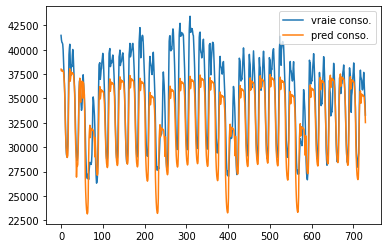

In [12]:
plt.plot(y[-365*2:], label="vraie conso.")
plt.plot(oof[-365*2:], label="pred conso.")
plt.legend(loc="best")
plt.show()

On voit qu'on arrive à repliquer la tendance, mais par définion la regression cible la moyenne. Par ailleurs avec la métrique MAE on cible la médiane. **Donc il serait intéressant de faire une regression quantile**.

In [13]:
df_te["Consommation"] = pred
df_te[["Date","Heure","Consommation"]].to_csv("./subs/ols.csv", index=False)

## B- RESEAU DE NEURONES

## C- BOOSTING MODELS (LightGBM)